In [1]:
%pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_data(filepath: str) -> pd.DataFrame:
    """
    Carrega os dados do arquivo CSV e realiza transformações iniciais.
    
    Args:
        filepath: Caminho para o arquivo CSV
        
    Returns:
        DataFrame com os dados carregados e processados
    """
    df = pd.read_csv(
        filepath, 
        names=['arquivo', 'k', 'best_ans', 'tempo_ms'],
        header=None
    )
    
    # Converter tempo de milissegundos para segundos
    df['tempo_seconds'] = df['tempo_ms'] / 1000.0
    
    return df

def print_dataset_info(df: pd.DataFrame) -> None:
    """Exibe informações resumidas sobre o dataset."""
    print(f"Total de registros: {len(df):,}")
    print(f"\nPrimeiras linhas:")
    print(df.head())
    print(f"\nEstatísticas:")
    print(df[['best_ans', 'tempo_seconds']].describe())

# Carregar dados
df = load_data('../Results/result-8.csv')
print_dataset_info(df)

Total de registros: 64,899

Primeiras linhas:
                                arquivo   k  best_ans  tempo_ms  tempo_seconds
0  ./Dataset/type1/classe_1_100_100.txt  11         6      51.0          0.051
1  ./Dataset/type1/classe_1_100_100.txt  11         6     102.0          0.102
2  ./Dataset/type1/classe_1_100_100.txt  11         7     152.0          0.152
3  ./Dataset/type1/classe_1_100_100.txt  11         7     202.0          0.202
4  ./Dataset/type1/classe_1_100_100.txt  11         7     252.0          0.252

Estatísticas:
           best_ans  tempo_seconds
count  64899.000000    64899.00000
mean      21.950646       20.05803
std       24.021470       11.54886
min        1.000000        0.00500
25%        3.000000       10.04700
50%       10.000000       20.07700
75%       39.000000       30.05200
max      192.000000       46.79600


## Análise Comparativa: Evolução das Soluções

In [3]:
def prepare_time_series_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara dados de série temporal com preenchimento de valores ausentes.
    Otimizado usando operações vetorizadas do pandas.
    
    Args:
        df: DataFrame original com dados
        
    Returns:
        DataFrame com médias por instância e grupo de tempo
    """
    # Preparar dados base
    df_sorted = df.sort_values('tempo_ms').copy()
    df_sorted['tempo_seconds_arounded'] = df_sorted['tempo_seconds'].round(2)
    
    # Agrupar por instância e tempo arredondado, calculando a média
    df_grouped = df_sorted.groupby(
        ['arquivo', 'tempo_seconds_arounded'], 
        as_index=False
    ).agg({'best_ans': 'mean'})
    
    # Criar índice completo (todas combinações de instância x tempo)
    instances = df['arquivo'].unique()
    time_groups = df_sorted['tempo_seconds_arounded'].unique()
    
    # Criar MultiIndex com todas as combinações
    full_index = pd.MultiIndex.from_product(
        [instances, sorted(time_groups)],
        names=['arquivo', 'tempo_seconds_arounded']
    )
    
    # Reindexar para incluir todas as combinações
    df_complete = df_grouped.set_index(['arquivo', 'tempo_seconds_arounded']).reindex(full_index)
    
    # Preencher valores ausentes com forward fill (propaga último valor válido)
    # e depois com 0 para os casos onde não há valor anterior
    df_complete['best_ans'] = df_complete.groupby(level='arquivo')['best_ans'].ffill().fillna(0)
    
    # Resetar índice e adicionar colunas auxiliares
    df_result = df_complete.reset_index()
    df_result['tempo_ms'] = df_result['tempo_seconds_arounded'] * 1000.0
    df_result['tempo_seconds'] = df_result['tempo_seconds_arounded']
    df_result['k'] = np.nan
    
    # Reordenar colunas para manter consistência
    df_result = df_result[['arquivo', 'k', 'best_ans', 'tempo_ms', 'tempo_seconds', 'tempo_seconds_arounded']]
    
    return df_result

# Preparar dados otimizado
df_intances_mean_by_group_time = prepare_time_series_data(df)
print(f"Shape: {df_intances_mean_by_group_time.shape}")
df_intances_mean_by_group_time.head(10)

Shape: (406000, 6)


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,0.0,0.00,0.00
1,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,10.0,0.01,0.01
2,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,20.0,0.02,0.02
3,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,30.0,0.03,0.03
4,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,40.0,0.04,0.04
5,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,50.0,0.05,0.05
6,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,60.0,0.06,0.06
7,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,70.0,0.07,0.07
8,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,80.0,0.08,0.08
9,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,90.0,0.09,0.09


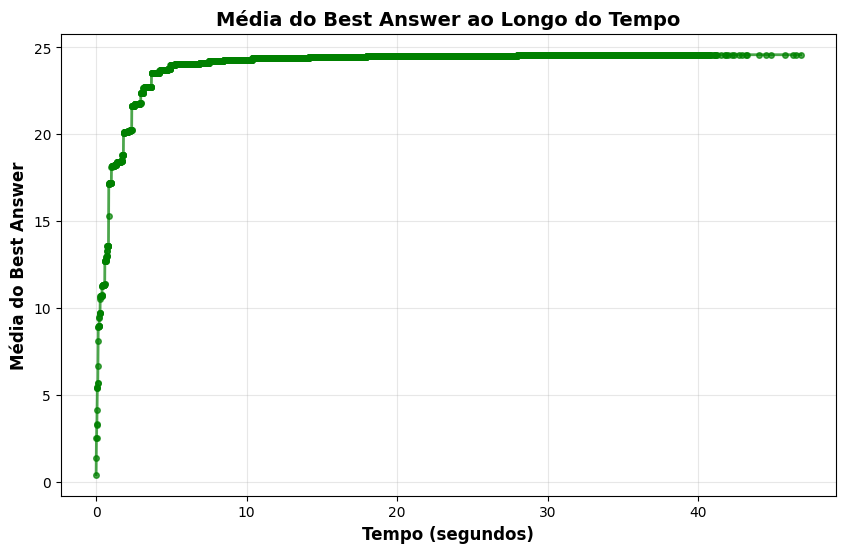

In [4]:
# Plotar gráfico da média do best_ans ao longo do tempo
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_intances_mean_by_group_time.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
def calculate_improvement_statistics(mean_by_time: pd.DataFrame, 
                                   df: pd.DataFrame) -> dict:
    """
    Calcula estatísticas de melhoria do algoritmo.
    
    Args:
        mean_by_time: DataFrame com média ao longo do tempo
        df: DataFrame com todos os dados
        
    Returns:
        Dicionário com estatísticas de melhoria
    """
    mean_inicial = mean_by_time['mean_best'].iloc[0]
    mean_final = mean_by_time['mean_best'].iloc[-1]
    melhoria_absoluta = mean_final - mean_inicial
    melhoria_percentual = ((mean_final / mean_inicial) - 1) * 100 if mean_inicial > 0 else 0
    
    return {
        'total_execucoes': len(df),
        'total_instancias': len(df['arquivo'].unique()),
        'media_inicial': mean_inicial,
        'media_final': mean_final,
        'melhoria_absoluta': melhoria_absoluta,
        'melhoria_percentual': melhoria_percentual
    }

def print_improvement_statistics(stats: dict) -> None:
    """
    Exibe estatísticas de melhoria formatadas.
    
    Args:
        stats: Dicionário com estatísticas calculadas
    """
    print("=" * 80)
    print("ESTATÍSTICAS DE MELHORIA")
    print("=" * 80)
    print(f"\nTotal de execuções: {stats['total_execucoes']:,}")
    print(f"Total de instâncias: {stats['total_instancias']}")
    print(f"\nMédia inicial: {stats['media_inicial']:.2f}")
    print(f"Média final: {stats['media_final']:.2f}")
    print(f"Melhoria absoluta: {stats['melhoria_absoluta']:.2f}")
    print(f"Melhoria percentual: {stats['melhoria_percentual']:.2f}%")

# Calcular e exibir estatísticas
stats = calculate_improvement_statistics(df_intances_mean_by_group_time, df)
print_improvement_statistics(stats)

KeyError: 'mean_best'